In [1]:
import random 
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import library_data_science as lds

In [2]:
def cross_validation(X_train: list, Y_train: list, X_test: list, Y_test: list, trials = 10, display = False) -> list:
    r_square = 0
    factors = []

    for n in range(1, trials + 1):
        factors_predicted = np.polyfit(X_train, Y_train, n)
        Y_predicted_test = [ lds.polynomial(x, factors_predicted) for x in X_test ]
        r_square_current = lds.r_square(Y_test, Y_predicted_test)

        if r_square < r_square_current:
            r_square = r_square_current
            factors = factors_predicted
        
        if display:
            X = np.linspace(min(X_test), max(X_test), num = 1000)
            Y = [ lds.polynomial(x, factors_predicted) for x in X]

            plt.scatter(X_test, Y_test)
            plt.plot(X, Y, color = 'red', label = f'n = {n}, R^2 = {r_square_current}')

            plt.legend()
            plt.xlabel('X_test')
            plt.ylabel('Y_test')
            plt.show()
    
    result_factors = [ float(datum) for datum in factors ]
    result_r_square = float(r_square)
    
    return result_factors, result_r_square, len(result_factors)


def best_cross_validation(results: tuple) -> tuple:
    best = results[0]
    for result in results:
        if result[1] > best[1]:
            best = result
    return best

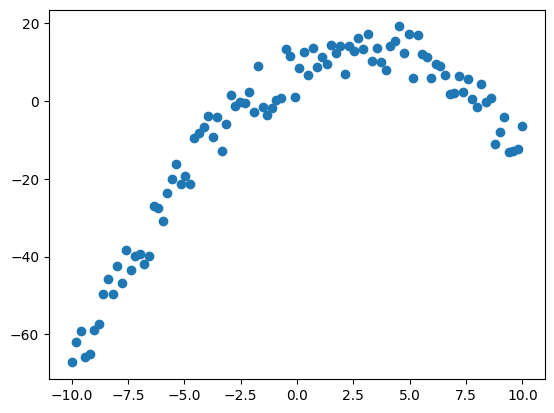

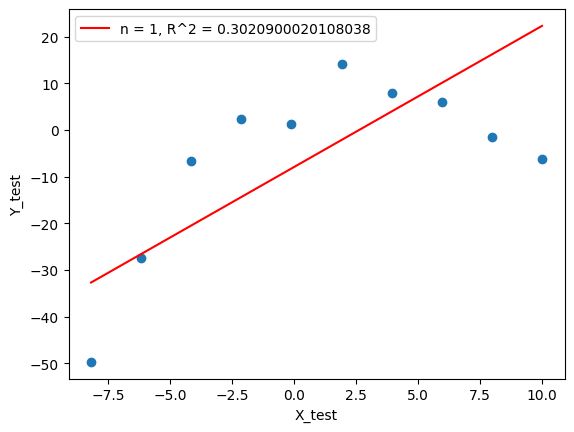

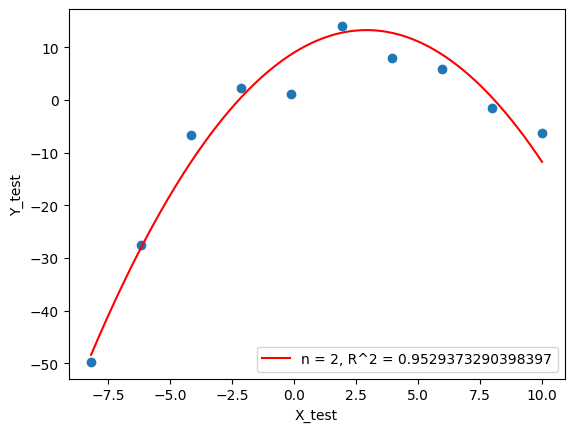

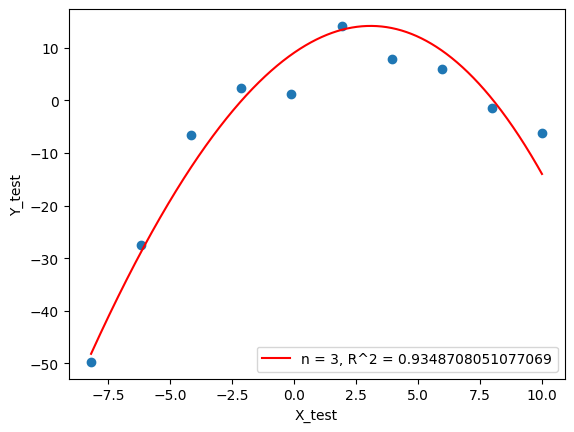

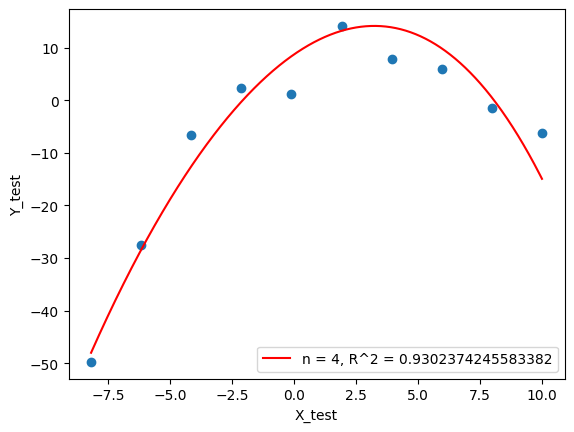

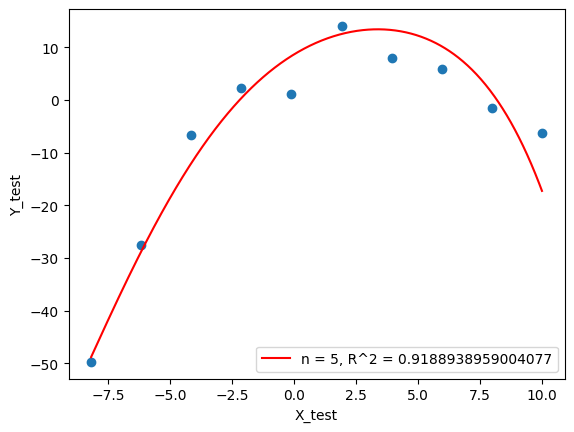

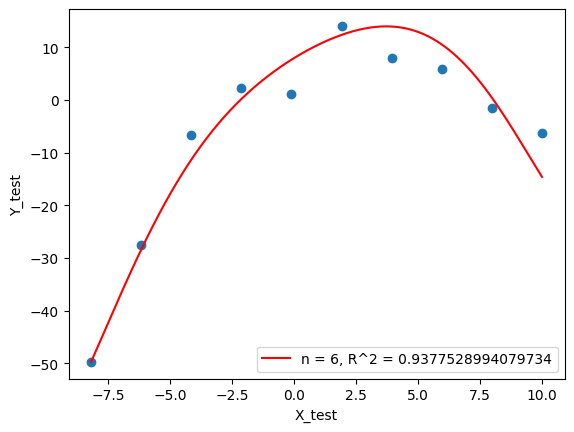

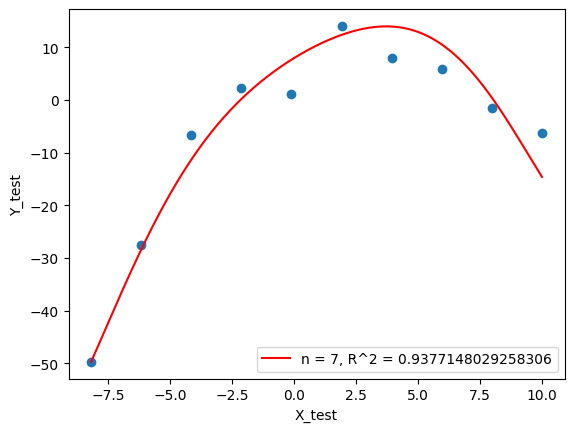

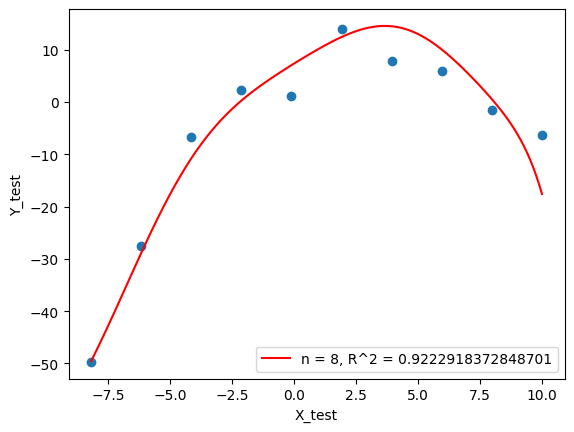

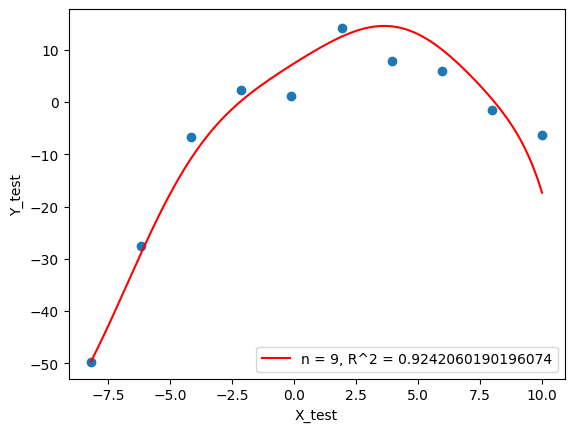

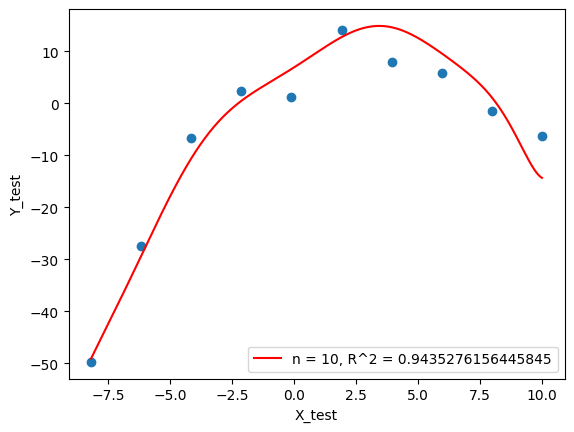

([-0.4995687010428456, 2.9230477805350157, 8.988113790615962], 0.9529373290398397, 3) 3


In [3]:
X = np.linspace(-10, 10, num = 100)
Y = [ lds.polynomial(x, (-0.5, 3, 1)) + (15 * random.random()) for x in X  ]

plt.scatter(X, Y)
plt.show()

X_train = []
Y_train = []
X_test = []
Y_test = []

for i in range(len(X)):
    if (i + 1) % 10 == 0:
        X_test.append(X[i])
        Y_test.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])

factors = cross_validation(X_train, Y_train, X_test, Y_test, display = True)
print(factors, len(factors))

In [4]:
def leave_one_out_cross_validation(X: list, Y: list, trials = 10, display = False) -> list:
    results = []

    for i in range(len(X)):
        X_train = []
        Y_train = []
        X_test = []
        Y_test = []

        for j in range(len(X)):
            if i == j:
                X_test.append(X[j])
                Y_test.append(Y[j])
            else:
                X_train.append(X[j])
                Y_train.append(Y[j])
        
        model = cross_validation(X_train, Y_train, X_test, Y_test, trials, display)
        
        results.append(model)
    
    return list(results)

In [5]:
loo = leave_one_out_cross_validation(X, Y)
print(loo)
print(best_cross_validation(loo))

[([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 0.0, 0), ([], 

/Users/danielfaltynowski/Documents/Repositories/learn-data-science/library_data_science.py:277: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (residual_sum_of_squares(Y_observed, Y_predicted) / (variance(Y_observed) * len(Y_observed)))


In [6]:
def k_fold_cross_validation(X: list, Y: list, k: int, trials = 10, display = False) -> list:
    results = []

    for i in range(k):
        X_train = []
        Y_train = []
        X_test = []
        Y_test = []

        for j in range(len(X)):
            if (j + i) % k == 0:
                X_test.append(X[j])
                Y_test.append(Y[j])
            else:
                X_train.append(X[j])
                Y_train.append(Y[j])
        
        model = cross_validation(X_train, Y_train, X_test, Y_test, trials, display)
        
        results.append(model)
    
    return list(results)

In [7]:
kf = k_fold_cross_validation(X, Y, 5)
print(kf)
print(best_cross_validation(kf))

[([-4.075373887772303e-05, -3.584693279115622e-05, 0.0009719179871912916, -0.49866482852302707, 3.0228193237440184, 8.975000540313982], 0.9746991328026641, 6), ([-0.4973215619264273, 2.9013825565434614, 9.140348029673929], 0.9667876755386023, 3), ([-0.0031017575980720703, -0.48764024486958946, 3.1552126556262294, 8.631605995897273], 0.9645794720479988, 4), ([5.516725118140104e-08, 1.3242526765116922e-07, -1.3525312460065075e-05, -2.7338250478431915e-05, 0.0012082526977010527, 0.0017734407348879136, -0.04745857834829428, -0.03873743743069459, 0.239634594739499, 3.1587814050806875, 6.285705920320797], 0.9665476097507224, 11), ([2.9529256232664454e-08, 4.5157058438540636e-05, -3.4791558780806185e-05, -0.006581465130408267, 0.0025648969421491813, -0.25076429127762306, 2.8839924692653733, 7.382591170267756], 0.9744923434883141, 8)]
([-4.075373887772303e-05, -3.584693279115622e-05, 0.0009719179871912916, -0.49866482852302707, 3.0228193237440184, 8.975000540313982], 0.9746991328026641, 6)


In [8]:
def repeated_random_sampling(X: list, Y: list, num_samples: int, sample_size: int, trials = 10, display = False) -> list:
    results = []

    for i in range(num_samples):
        indexes = random.sample(list(range(len(X))), sample_size)

        X_test = []
        Y_test = []
        X_train = []
        Y_train = []

        for j in range(len(X)):
            if j in indexes:
                X_test.append(X[j])
                Y_test.append(Y[j])
            else:
                X_train.append(X[j])
                Y_train.append(Y[j])
        
        model = cross_validation(X_train, Y_train, X_test, Y_test, trials, display)
        
        results.append(model)
    
    return list(results)

In [9]:
rr = repeated_random_sampling(X, Y, 5, 50)
print(rr)
print(best_cross_validation(rr))

[([-0.5080787853041727, 2.916764078684272, 9.967424389191757], 0.9588044441208793, 3), ([-0.0022982286234560696, -0.4764993618380005, 2.8667138273401243, 7.791233708986413], 0.9713406219912392, 4), ([1.8923750906465518e-08, 1.6178907998442274e-07, -4.877832188607017e-06, -3.428762931719863e-05, 0.0004551715130401727, 0.00222110029822393, -0.018085210221632356, -0.04386356545165229, -0.23085886566555666, 3.033920135431604, 7.576892584175359], 0.9669164078033854, 11), ([-0.0035960518052902276, -0.49427163415319175, 3.0806731937917684, 9.083166752229236], 0.9683140364115538, 4), ([2.8203736276737285e-08, 1.0639280862183894e-07, -7.796304299887546e-06, -1.901761882490387e-05, 0.0008107154812663831, 0.0008708944020291257, -0.03771874811580455, -0.0015943451720403714, 0.19463937730523143, 2.7290581123766255, 7.288083478699692], 0.9612803900119621, 11)]
([-0.0022982286234560696, -0.4764993618380005, 2.8667138273401243, 7.791233708986413], 0.9713406219912392, 4)
